In [ ]:
import torch
import torchvision
# import torchtext
import torchaudio

print(f"PyTorch version: {torch.__version__}")
print(f"TorchVision version: {torchvision.__version__}")
# print(f"TorchText version: {torchtext.__version__}")
print(f"TorchAudio version: {torchaudio.__version__}")

try:
    print(torchvision.extension._check_cuda_version())
    print("\nTorchVision and Torch are correctly linked.")
except Exception as e:
    print(f"\nVerification failed with error: {e}")

PyTorch version: 2.6.0+cu124
TorchVision version: 0.21.0+cu124
TorchAudio version: 2.6.0+cu124
12040

TorchVision and Torch are correctly linked.


In [ ]:
#Imports and Styling
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from PIL import Image
import os, warnings
warnings.filterwarnings('ignore')
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as T
import torch.nn.functional as F
torch.backends.cudnn.benchmark = True
import math
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
image_dir = "/kaggle/input/chest-xrays-indiana-university/images/images_normalized"
iprojection_dir = "/kaggle/input/chest-xrays-indiana-university/indiana_projections.csv"
ireport_dir = "/kaggle/input/chest-xrays-indiana-university/indiana_reports.csv"
# image_dir, iprojection_dir, ireport_dir
projections = pd.read_csv(iprojection_dir)
reports     = pd.read_csv(ireport_dir)

# Binary Classification

In [ ]:
# --- Dataset Class ---
class ChestXrayBinary(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.projections_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.label_map = {'frontal': 0, 'lateral': 1}
        # Filter out rows where the image file might not exist
        self.projections_frame['image_exists'] = self.projections_frame['filename'].apply(lambda x: os.path.exists(os.path.join(self.root_dir, x)))
        self.projections_frame = self.projections_frame[self.projections_frame['image_exists']].reset_index(drop=True)

    def __len__(self):
        return len(self.projections_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        img_name = os.path.join(self.root_dir, self.projections_frame.iloc[idx]['filename'])
        image = Image.open(img_name).convert('RGB')
        projection = self.projections_frame.iloc[idx]['projection']
        label = self.label_map[projection.lower()]
        if self.transform:
            image = self.transform(image)
        return image, label
# --- Data Preparation and 3-Way Split (with Augmentation) ---

# Define transformations
# 1. Transformations for the training set with data augmentation
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),  # Randomly flip images horizontally
    transforms.RandomRotation(10),       # Randomly rotate images by up to 10 degrees
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 2. Transformations for the validation and test sets (no augmentation)
val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

csv_path = iprojection_dir
image_directory = image_dir

# Instantiate the full dataset with the standard (non-augmented) transform first
# We will apply the specific transforms after the split
try:
    full_dataset = ChestXrayBinary(csv_file=csv_path, root_dir=image_directory, transform=val_test_transform)
except FileNotFoundError:
    print("Error: Projections CSV or image directory not found. Using dummy data for demonstration.")
    full_dataset = [(torch.randn(3, 224, 224), np.random.randint(0, 2)) for _ in range(200)]

# Define split sizes
dataset_size = len(full_dataset)
train_size = int(0.7 * dataset_size)
val_size = int(0.15 * dataset_size)
test_size = dataset_size - train_size - val_size # Ensure all data is used

# Split the dataset
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

# The train_dataset gets the augmented transforms
train_dataset.dataset.transform = train_transform
# The validation and test datasets get the standard, non-augmented transforms
val_dataset.dataset.transform = val_test_transform
test_dataset.dataset.transform = val_test_transform

# Create DataLoaders for each set
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print(f"Total dataset size: {dataset_size}")
print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Using device: cuda:0
Total dataset size: 7466
Train dataset size: 5226
Validation dataset size: 1119
Test dataset size: 1121


In [ ]:
# --- Training, Plotting, and Testing Function ---
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=50):
    """Trains the model, validating against the validation set each epoch."""
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    for epoch in range(num_epochs):
        model.train()
        train_loss, train_correct, train_total = 0, 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
        history['train_loss'].append(train_loss / train_total)
        history['train_acc'].append(train_correct / train_total)

        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        history['val_loss'].append(val_loss / val_total)
        history['val_acc'].append(val_correct / val_total)
        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {history['train_loss'][-1]:.4f} | Val Loss: {history['val_loss'][-1]:.4f} | Val Acc: {history['val_acc'][-1]:.4f}")
    return history
def plot_history(history, model_name):
    """Plots training/validation loss and accuracy."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle(f'Performance of {model_name}', fontsize=16)
    ax1.plot(history['train_acc'], label='Train Accuracy'); ax1.plot(history['val_acc'], label='Validation Accuracy')
    ax1.set_title('Model Accuracy'); ax1.set_ylabel('Accuracy'); ax1.set_xlabel('Epoch'); ax1.legend(); ax1.grid(True)
    ax2.plot(history['train_loss'], label='Train Loss'); ax2.plot(history['val_loss'], label='Validation Loss')
    ax2.set_title('Model Loss'); ax2.set_ylabel('Loss'); ax2.set_xlabel('Epoch'); ax2.legend(); ax2.grid(True)
    plt.show()

def test_model_detailed(model, criterion, test_loader):
    """
    Evaluates the model on the test set and provides a detailed report
    including a classification report and a confusion matrix.
    """
    print("\n--- Evaluating on Test Set ---")
    model.eval()
    test_loss, test_correct, test_total = 0, 0, 0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)

            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

            # Store labels and predictions for detailed metrics
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    final_loss = test_loss / test_total
    final_acc = test_correct / test_total
    print(f"Final Test Loss: {final_loss:.4f}")
    print(f"Final Test Accuracy: {final_acc:.4f}\n")

    # 1. Classification Report
    target_names = ['frontal', 'lateral']
    print("--- Classification Report ---")
    print(classification_report(all_labels, all_preds, target_names=target_names))

    # 2. Confusion Matrix
    print("\n--- Confusion Matrix ---")
    cm = confusion_matrix(all_labels, all_preds)
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=target_names, yticklabels=target_names)
    ax.set_title('Confusion Matrix', fontsize=16)
    ax.set_xlabel('Predicted Label', fontsize=12)
    ax.set_ylabel('True Label', fontsize=12)
    plt.show()


--- Training Pretrained ResNet18 ---
Epoch 1/10 | Train Loss: 0.1090 | Val Loss: 0.0270 | Val Acc: 0.9964
Epoch 2/10 | Train Loss: 0.0297 | Val Loss: 0.0151 | Val Acc: 0.9982
Epoch 3/10 | Train Loss: 0.0169 | Val Loss: 0.0129 | Val Acc: 0.9973
Epoch 4/10 | Train Loss: 0.0166 | Val Loss: 0.0074 | Val Acc: 0.9991
Epoch 5/10 | Train Loss: 0.0115 | Val Loss: 0.0077 | Val Acc: 0.9991
Epoch 6/10 | Train Loss: 0.0116 | Val Loss: 0.0056 | Val Acc: 1.0000
Epoch 7/10 | Train Loss: 0.0158 | Val Loss: 0.0052 | Val Acc: 1.0000
Epoch 8/10 | Train Loss: 0.0094 | Val Loss: 0.0046 | Val Acc: 0.9991
Epoch 9/10 | Train Loss: 0.0104 | Val Loss: 0.0052 | Val Acc: 0.9973
Epoch 10/10 | Train Loss: 0.0097 | Val Loss: 0.0053 | Val Acc: 0.9973


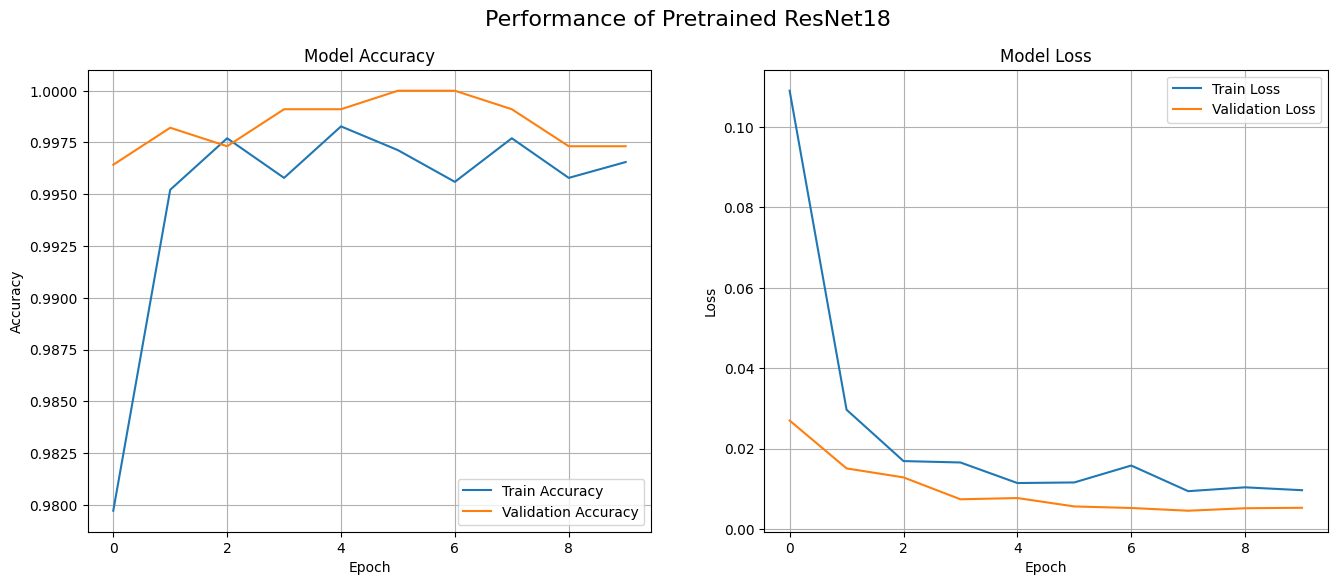


--- Evaluating on Test Set (Detailed) ---
Final Test Loss: 0.0026
Final Test Accuracy: 1.0000

--- Classification Report ---
              precision    recall  f1-score   support

     frontal       1.00      1.00      1.00       541
     lateral       1.00      1.00      1.00       580

    accuracy                           1.00      1121
   macro avg       1.00      1.00      1.00      1121
weighted avg       1.00      1.00      1.00      1121


--- Confusion Matrix ---


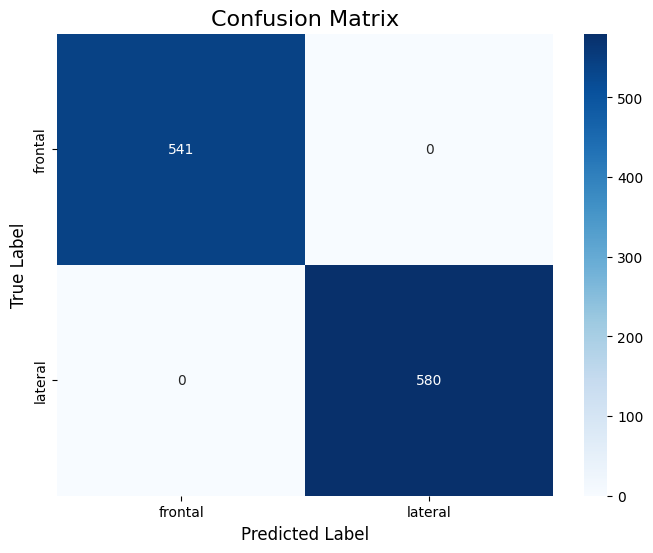

In [ ]:
# --- Model Definition (ResNet18) ---
model_resnet18 = models.resnet18(pretrained=True)
for param in model_resnet18.parameters():
    param.requires_grad = False

num_ftrs = model_resnet18.fc.in_features
model_resnet18.fc = nn.Linear(num_ftrs, 2) # 2 classes
model_resnet18 = model_resnet18.to(device)

# --- Define Criterion and Optimizer ---
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_resnet18.fc.parameters(), lr=0.001)

# --- 1. Train the model ---
print("\n--- Training Pretrained ResNet18 ---")
resnet_history = train_model(model_resnet18, criterion, optimizer, train_loader, val_loader, num_epochs=10)

# --- 2. Visualize training progress ---
plot_history(resnet_history, "Pretrained ResNet18")

# --- 3. Evaluate the final model on the test set ---
test_model_detailed(model_resnet18, criterion, test_loader)


--- Training Simple CNN ---
Epoch 1/10 | Train Loss: 0.0934 | Val Loss: 0.0194 | Val Acc: 0.9911
Epoch 2/10 | Train Loss: 0.0159 | Val Loss: 0.0175 | Val Acc: 0.9929
Epoch 3/10 | Train Loss: 0.0127 | Val Loss: 0.0276 | Val Acc: 0.9911
Epoch 4/10 | Train Loss: 0.0138 | Val Loss: 0.0106 | Val Acc: 0.9973
Epoch 5/10 | Train Loss: 0.0061 | Val Loss: 0.0183 | Val Acc: 0.9955
Epoch 6/10 | Train Loss: 0.0036 | Val Loss: 0.0269 | Val Acc: 0.9920
Epoch 7/10 | Train Loss: 0.0174 | Val Loss: 0.0196 | Val Acc: 0.9955
Epoch 8/10 | Train Loss: 0.0070 | Val Loss: 0.0102 | Val Acc: 0.9982
Epoch 9/10 | Train Loss: 0.0026 | Val Loss: 0.0118 | Val Acc: 0.9973
Epoch 10/10 | Train Loss: 0.0002 | Val Loss: 0.0137 | Val Acc: 0.9982


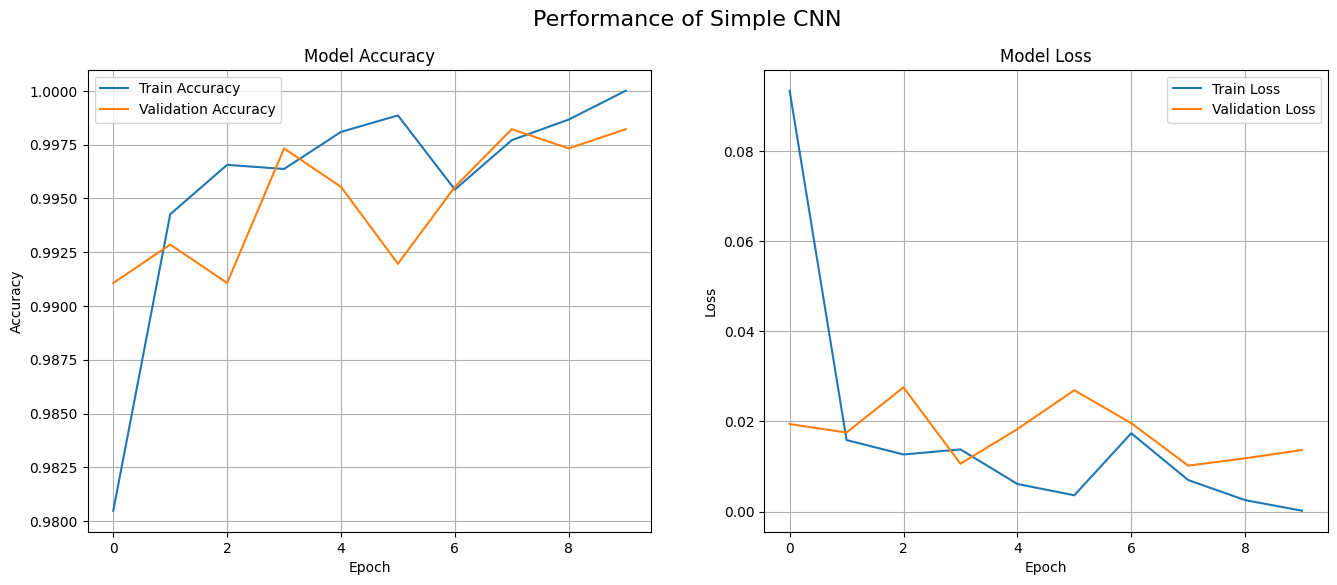


--- Evaluating on Test Set (Detailed) ---
Final Test Loss: 0.0056
Final Test Accuracy: 0.9982

--- Classification Report ---
              precision    recall  f1-score   support

     frontal       1.00      1.00      1.00       541
     lateral       1.00      1.00      1.00       580

    accuracy                           1.00      1121
   macro avg       1.00      1.00      1.00      1121
weighted avg       1.00      1.00      1.00      1121


--- Confusion Matrix ---


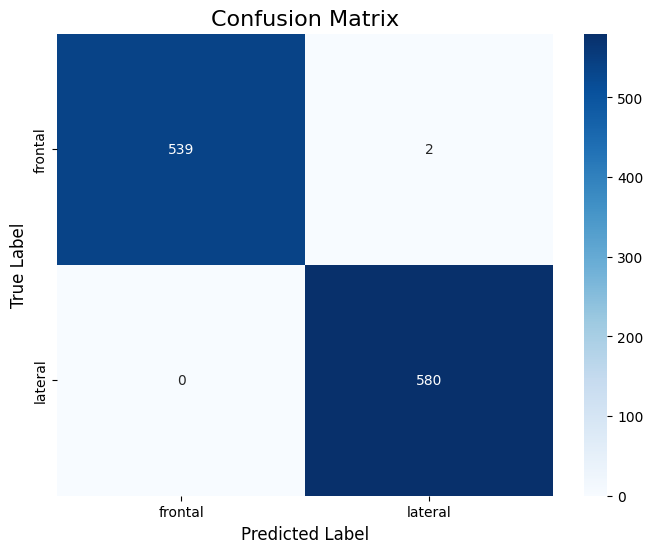

In [ ]:
# --- Model Definition (Simple CNN) ---
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        # After two pooling layers, 224x224 image becomes 224/2/2 = 56x56
        self.fc1 = nn.Linear(32 * 56 * 56, 128)
        self.fc2 = nn.Linear(128, 2) # 2 classes: frontal/lateral

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 56 * 56) # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Instantiate the model and move it to the correct device
model_simple_cnn = SimpleCNN().to(device)

# --- Define Criterion and Optimizer ---
criterion = nn.CrossEntropyLoss()
# For the simple CNN, we train all parameters
optimizer = optim.Adam(model_simple_cnn.parameters(), lr=0.001)

# --- 1. Train the model ---
print("\n--- Training Simple CNN ---")
# Use the generic training function to get the history
cnn_history = train_model(model_simple_cnn, criterion, optimizer, train_loader, val_loader, num_epochs=10)

# --- 2. Visualize training and validation progress ---
# Use the generic plotting function
plot_history(cnn_history, "Simple CNN")

# --- 3. Evaluate the final model on the unseen test set ---
# Use the generic testing function
test_model_detailed(model_simple_cnn, criterion, test_loader)